### ***SMOTE***

SMOTE is the acronym of *"Synthetic Minority Oversampling Technique"* and in the paper is used to face the class imbalance problem. As highlighted by the following cell, only $492$ of the total $284807$ transactions are fraudolent ($0.172\%$). 
This imbalance can lead to models being biased toward the majority class, so that fraudulent transactions (minority class) may be overshadowed by the legitimate ones.

One solution could be duplicating samples during training: with this, tough, the model could not improve its model.  
Viceversa, SMOTE, generates synthetic samples by interpolating between existing minority samples and their nearest neighbors in feature space. Thus, it moves the decision boundary closer to the majority class while maintaining the diversity of the minority class distribution: for example, if $x_i$ and $x_{j}$ are closely clustered minority samples, the synthetic sample $x_{\text{synthetic}}$ lies on the line connecting them, ensuring it represents the local structure of the minority class.


The algorithm is the following:
$$
\begin{aligned}
\textbf{SMOTE}(M: \text{minorities set}, n_{samples}: \text{number of synthetic samples to generate}, k: \text{number of neighbors to compute}) \rightarrow \\
\quad S: \text{set of synthetic samples}
\end{aligned}
$$

$$
\begin{aligned}
& S \leftarrow [\,\,] \quad \text{//Initialize an empty set of synthetic samples} \\
& \text{for each } x_i \in M: \\
& \quad \text{neigh} \leftarrow \text{Neighbors}(x_i, k + 1) \quad \text{//Find $k+1$ neighbors of $x_i$} \\
& \quad \text{Choose one } x_j \text{ from neigh randomly}\\
& \quad x_{\text{synthetic}} = x_i + \lambda (x_j - x_i), \quad //\text{Generate a new sample with } \lambda \sim U(0, 1) \\
& \quad S = S + x_{\text{synthetic}} \quad \text{//Add the synthetic sample to the set} \\

\\
& \text{Return } \, S
\end{aligned}
$$

In [2]:
import pandas as pd
import numpy as np

data = pd.read_csv("../creditcard_2021.csv")
print(f"Number of samples: {len(data)}")
print(f"Number of fraudolent transaction: {(data['Class'] == 1).sum()}")
print(f"Ratio of fraudolent transaction: {data['Class'].mean()}")

Number of samples: 284807
Number of fraudolent transaction: 492
Ratio of fraudolent transaction: 0.001727485630620034


#### ***Algorithm implementation***

In [3]:
import jax
import jax.numpy as jnp
from jax import random
from sklearn import neighbors 
from functools import partial

In [4]:
@partial(jax.jit, static_argnums = (1,))
def generate_synthetic_samples(X_minority, n_samples, indices):
    """
        This is an helper function that is used to generate synthetic samples using the SMOTE algorithm.
        It's JIT-compiled, and the `indices` argument is marked as a static argument for performance.
        
        Args:
            X_minority: array of minority class samples (input feature vectors).
            n_samples: number of synthetic samples to generate.
            indices: array of indices for the nearest neighbors of each minority sample.
            
        Returns:
            A JAX array of synthetic samples.
    """

    key = random.PRNGKey(0)

    n_minority_samples = X_minority.shape[0]

    key, subkey1, subkey2 = random.split(key, 3)

    #Randomly select indices of minority samples to base synthetic samples on
    sample_indices = random.randint(subkey1, (n_samples,), 0, n_minority_samples)

    #Randomly select one of the nearest neighbors for each chosen sample
    neighbor_choices = random.randint(subkey2, (n_samples,), 1, indices.shape[1])

    #"selected samples" are the sample chosen to interpolate from
    selected_samples = X_minority[sample_indices] 

    #Neighbors can be found by indexing the nearest neighbors array with the chosen indices
    selected_neighbors = X_minority[indices[sample_indices, neighbor_choices]]  

    #Generate random interpolation factors (gaps) between 0 and 1
    key, subkey3 = random.split(key)
    gaps = random.uniform(subkey3, (n_samples, 1))

    #Place the syntetic point by interpolating between the selected sample and its neighbor
    diffs = selected_neighbors - selected_samples
    synthetic = selected_samples + gaps * diffs

    return synthetic

In [5]:
def fit_resample(X_minority, n_samples, k = 5):
    """
        Main function to fit the data and generate synthetic samples, using JAX-accelerated SMOTE.  

        Args:
            X_minority: array of minority class samples (input feature vectors).
            n_samples: number of synthetic samples to generate.
            k: number of nearest neighbors to consider for SMOTE.
        
        Returns:
            A JAX array of synthetic samples.
    """

    X_minority = jnp.array(X_minority)

    #Initialize the NearestNeighbors model from scikit-learn
    #We use "k + 1" because the nearest neighbor should include the sample itself
    #Then, fit the nearest neighbors model on the minority samples
    neigh = neighbors.NearestNeighbors(n_neighbors = k + 1)
    neigh.fit(X_minority) 

    #Find the "k + 1" nearest neighbors for each minority sample
    #"indices" is a 2D array with the indices of the nearest neighbors for each sample
    _, indices = neigh.kneighbors(X_minority)
    indices = jnp.array(indices)

    #Call the synthetic sample generator
    return generate_synthetic_samples(X_minority, n_samples, indices)

#### ***Usage***

In [6]:
import pandas as pd
import numpy as np

data = pd.read_csv("../creditcard_2021.csv")
data = np.array(data)

#Note that here we are keeping the "Time" column: in the paper, there is no mention of removing it (also, "Time" is in attribute vector v5)
X_minority = data[data[:, 30] == 1]
target_n = 100000
synthetic = fit_resample(X_minority, n_samples = target_n)

In [7]:
#Rember that the array returned by the method is (target_n, 31), so you will need to add the starting rows (the ones with label == 1)
synthetic.shape

(100000, 31)

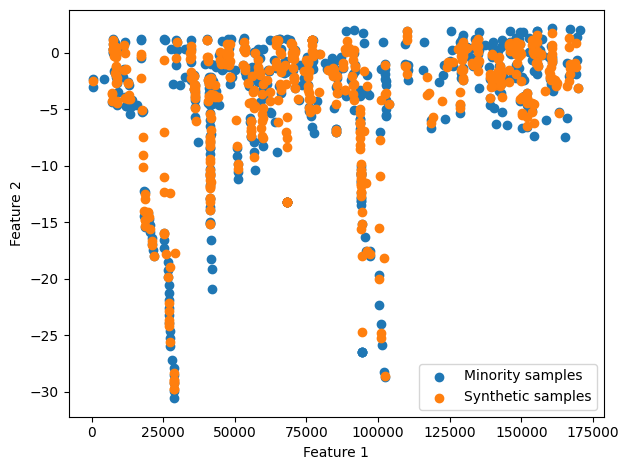

In [8]:
import matplotlib.pyplot as plt

n_samples = 500
plt.scatter(X_minority[:n_samples, 0], X_minority[:n_samples, 1], label = 'Minority samples')
plt.scatter(synthetic[:n_samples, 0], synthetic[:n_samples, 1], label = 'Synthetic samples')
plt.legend()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.tight_layout()
plt.show()